In [ ]:
import pytest, time
import copy
import itertools
from collections import OrderedDict
import matplotlib.pyplot as plt


from memory import Memory

# Dummy implementations to simulate the Mesa environment
timing_results = {}

class DummyModel:
    def __init__(self, steps=0):
        self.steps = steps

class DummyAgent:
    def __init__(self, agent_id, steps=0, capacity=10):
        self.id = agent_id
        self.model = DummyModel(steps)
        # Each agent has its own Memory instance.
        self.memory = Memory(self.model, agent_id, capacity)

def plot_timings():
    plt.clf()
    names = list(timing_results.keys())
    durations = list(timing_results.values())
    plt.barh(names, durations)
    plt.xlabel("Time (seconds)")
    plt.title("Test Execution Time")
    plt.tight_layout()
    plt.pause(0.1)

def timed_test(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        duration = time.perf_counter() - start
        timing_results[func.__name__] = duration
        print(f"{func.__name__} took {duration:.6f} seconds")
        plot_timings()  # Plot after each test
        return result
    return wrapper



In [ ]:

def test_remember_and_recall():
    """
    Test that remember stores an entry correctly and that recall retrieves the correct entry.
    """
    model = DummyModel(steps=5)
    memory = Memory(model, agent_id=1, capacity=5)
    
    entry_id = memory.remember("test_entry", "info")
    entry = memory.recall(entry_id)
    print(entry)
    
    assert entry["entry_content"] == "test_entry", (
        "test_remember_and_recall: entry_content does not match the expected value."
    )
    assert entry["entry_type"] == "info", (
        "test_remember_and_recall: entry_type does not match the expected value."
    )
    assert entry["entry_step"] == 5, (
        "test_remember_and_recall: steps do not match the model's steps value."
    )
    assert "external" not in entry, (
        "test_remember_and_recall: 'external' key should not be present when not provided."
    )
    print("passed")


def test_remember_with_external():
    """
    Test that remember adds external information if provided.
    """
    model = DummyModel(steps=10)
    memory = Memory(model, agent_id=2, capacity=5)
    dummy_external_agent = DummyAgent(agent_id=99)
    
    entry_id = memory.remember("external_test", "warning", external=dummy_external_agent)
    entry = memory.recall(entry_id)
    
    assert entry["entry_content"] == "external_test", (
        "test_remember_with_external: entry_content mismatch."
    )
    assert entry["entry_type"] == "warning", (
        "test_remember_with_external: entry_type mismatch."
    )
    assert entry["entry_step"] == 10, (
        "test_remember_with_external: steps mismatch."
    )
    assert "external" in entry, (
        "test_remember_with_external: 'external' key should be present when provided."
    )
    assert entry["external"] == dummy_external_agent, (
        "test_remember_with_external: external value does not match the provided agent."
    )


def test_capacity():
    """
    Test that the memory respects its capacity and that the oldest entry is removed when the capacity is exceeded.
    """
    model = DummyModel(steps=0)
    capacity = 3
    memory = Memory(model, agent_id=1, capacity=capacity)
    
    id1 = memory.remember("a", "test")
    id2 = memory.remember("b", "test")
    id3 = memory.remember("c", "test")
    
    # Check that memory is at full capacity
    assert len(memory.memory_storage) == capacity, (
        "test_capacity: Memory storage size does not match capacity before exceeding."
    )
    
    id4 = memory.remember("d", "test")
    assert len(memory.memory_storage) == capacity, (
        "test_capacity: Memory storage size exceeds capacity after adding an extra entry."
    )
    
    # The oldest entry (id1) should have been removed.
    assert id1 not in memory.memory_storage, (
        "test_capacity: Oldest entry was not removed when capacity was exceeded."
    )
    # The remaining entries should be in the order of insertion: id2, id3, id4.
    remaining_ids = list(memory.memory_storage.keys())
    assert remaining_ids == [id2, id3, id4], (
        "test_capacity: The order of remaining entries is incorrect after capacity exceeded."
    )
    print("passed")


def test_get_by_type():
    """
    Test that get_by_type returns only the IDs of entries matching the specified type.
    """
    model = DummyModel(steps=3)
    memory = Memory(model, agent_id=1, capacity=5)
    
    id1 = memory.remember("entry1", "x")
    id2 = memory.remember("entry2", "y")
    id3 = memory.remember("entry3", "x")
    
    x_entries = memory.get_by_type("x")
    y_entries = memory.get_by_type("y")
    
    assert id1 in x_entries and id3 in x_entries, (
        "test_get_by_type: Not all entries of type 'x' are returned."
    )
    assert id2 in y_entries, (
        "test_get_by_type: Entry of type 'y' is not returned."
    )
    # Ensure no extra entries are returned.
    assert len(x_entries) == 2, (
        "test_get_by_type: Incorrect number of entries returned for type 'x'."
    )
    assert len(y_entries) == 1, (
        "test_get_by_type: Incorrect number of entries returned for type 'y'."
    )
    print("passed")


def test_forget():
    """
    Test that forget correctly removes an entry from the memory.
    """
    model = DummyModel(steps=7)
    memory = Memory(model, agent_id=1, capacity=5)
    
    entry_id = memory.remember("to_forget", "temp")
    # Confirm that the entry is present before forgetting.
    assert entry_id in memory.memory_storage, (
        "test_forget: Entry not stored properly before calling forget."
    )
    
    memory.forget(entry_id)
    assert entry_id not in memory.memory_storage, (
        "test_forget: Entry was not removed from memory_storage after calling forget."
    )
    
    # Also, attempting to recall the forgotten entry should raise a KeyError.
    with pytest.raises(KeyError, match=""):
        _ = memory.recall(entry_id)
    print("passed")


def test_tell_to():
    """
    Test that tell_to sends a deep copy of an entry to another agent's memory with the correct external tag.
    """
    # Create two dummy agents.
    agent_a = DummyAgent(agent_id=1, steps=15)
    agent_b = DummyAgent(agent_id=2, steps=20)
    
    # Add an entry to agent A's memory.
    entry_id = agent_a.memory.remember("shared_data", "info")
    original_entry = agent_a.memory.recall(entry_id)
    
    # Before tell_to, agent B's memory should be empty.
    assert len(agent_b.memory.memory_storage) == 0, (
        "test_tell_to: Agent B's memory is not empty before receiving the entry."
    )
    
    # Agent A tells the entry to agent B.
    agent_a.memory.tell_to(agent_b, entry_id)
    
    # After telling, agent B's memory should have one new entry.
    assert len(agent_b.memory.memory_storage) == 1, (
        "test_tell_to: Agent B's memory did not receive the entry."
    )
    
    # Retrieve the new entry in agent B's memory.
    new_entry_id = next(iter(agent_b.memory.memory_storage))
    new_entry = agent_b.memory.memory_storage[new_entry_id]
    
    # Check that the new entry is a deep copy of the original.
    assert new_entry["entry_content"] == original_entry["entry_content"], (
        "test_tell_to: The entry content in agent B's memory does not match the original."
    )
    assert new_entry["entry_type"] == original_entry["entry_type"], (
        "test_tell_to: The entry type in agent B's memory does not match the original."
    )

    assert new_entry["external"] == agent_a.memory.agent_id, (
        "test_tell_to: The external tag in the copied entry is incorrect."
    )
    # Verify that the copy is deep by modifying the new entry and checking the original remains unchanged.
    new_entry["entry_content"] = "modified"
    assert original_entry["entry_content"] == "shared_data", (
        "test_tell_to: The deep copy was not made properly; the original entry was modified."
    )
    print("passed")


def test_recall_invalid():
    """
    Test that recalling a non-existent entry raises a KeyError.
    """
    model = DummyModel(steps=0)
    memory = Memory(model, agent_id=1, capacity=3)
    
    invalid_id = (1, 999)  # An ID that was never created.
    with pytest.raises(KeyError, match=""):
        _ = memory.recall(invalid_id)


OrderedDict({'entry_content': 'test_entry', 'entry_type': 'info', 'entry_step': 5})
passed
test_remember_and_recall took 0.000072 seconds


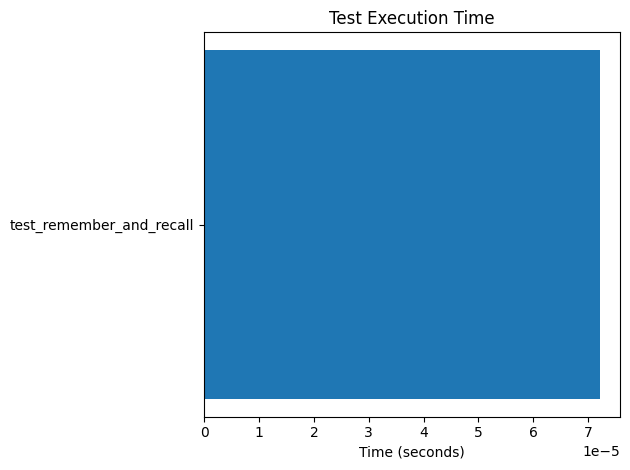

OrderedDict({'entry_content': 'external_test', 'entry_type': 'warning', 'entry_step': 10, 'external_agent_id': 99})


AssertionError: test_remember_with_external: 'external' key should be present when provided.

In [10]:
test_remember_and_recall()
test_remember_with_external()
test_capacity()
test_get_by_type()
test_forget()
test_tell_to()
test_recall_invalid()

long term :

```python
    def to_dict(self) -> Dict:
        """Convert long-term memory to dictionary for serialization."""
        return {
            "entries": {entry_id: entry.to_dict() for entry_id, entry in self.entries.items()},
        }
    
    @classmethod
    def from_dict(cls, data: Dict) -> 'LongTermMemory':
        """Create long-term memory from dictionary."""
        ltm = cls()
        
        for entry_id, entry_data in data["entries"].items():
            ltm.entries[entry_id] = MemoryEntry.from_dict(entry_data)
        
        return ltm
```


short term :
```python
    def to_dict(self) -> Dict:
        """Convert short-term memory to dictionary for serialization."""
        return {
            "capacity": self.capacity,
            "entries": [entry.to_dict() for entry in self.entries]
        }

    @classmethod
    def from_dict(cls, data: Dict) -> 'ShortTermMemory':
        """Create short-term memory from dictionary."""
        stm = cls(capacity=data["capacity"])
        for entry_data in data["entries"]:
            stm.add(MemoryEntry.from_dict(entry_data),self.model)
        return stm
```